In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as confusion_matrix

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

sns.axes_style(style=None, rc=None);

# Latex for graph labels
# !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
plt.rcParams['text.usetex'] = False;

# **Partie 1 : Utilisation des KPP**

In [2]:
titanic = sns.load_dataset('titanic')

In [3]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [5]:
titanic['who'] = titanic['who'].astype('category')
titanic['sex'] = titanic['sex'].astype('category')

In [6]:
titanic['family'] = titanic['sibsp'] + titanic['parch']
titanic = titanic.drop(['embarked','sibsp', 'parch', 'adult_male', 'deck', 'alive', 'class'], axis = 1)

On fait les graphes :

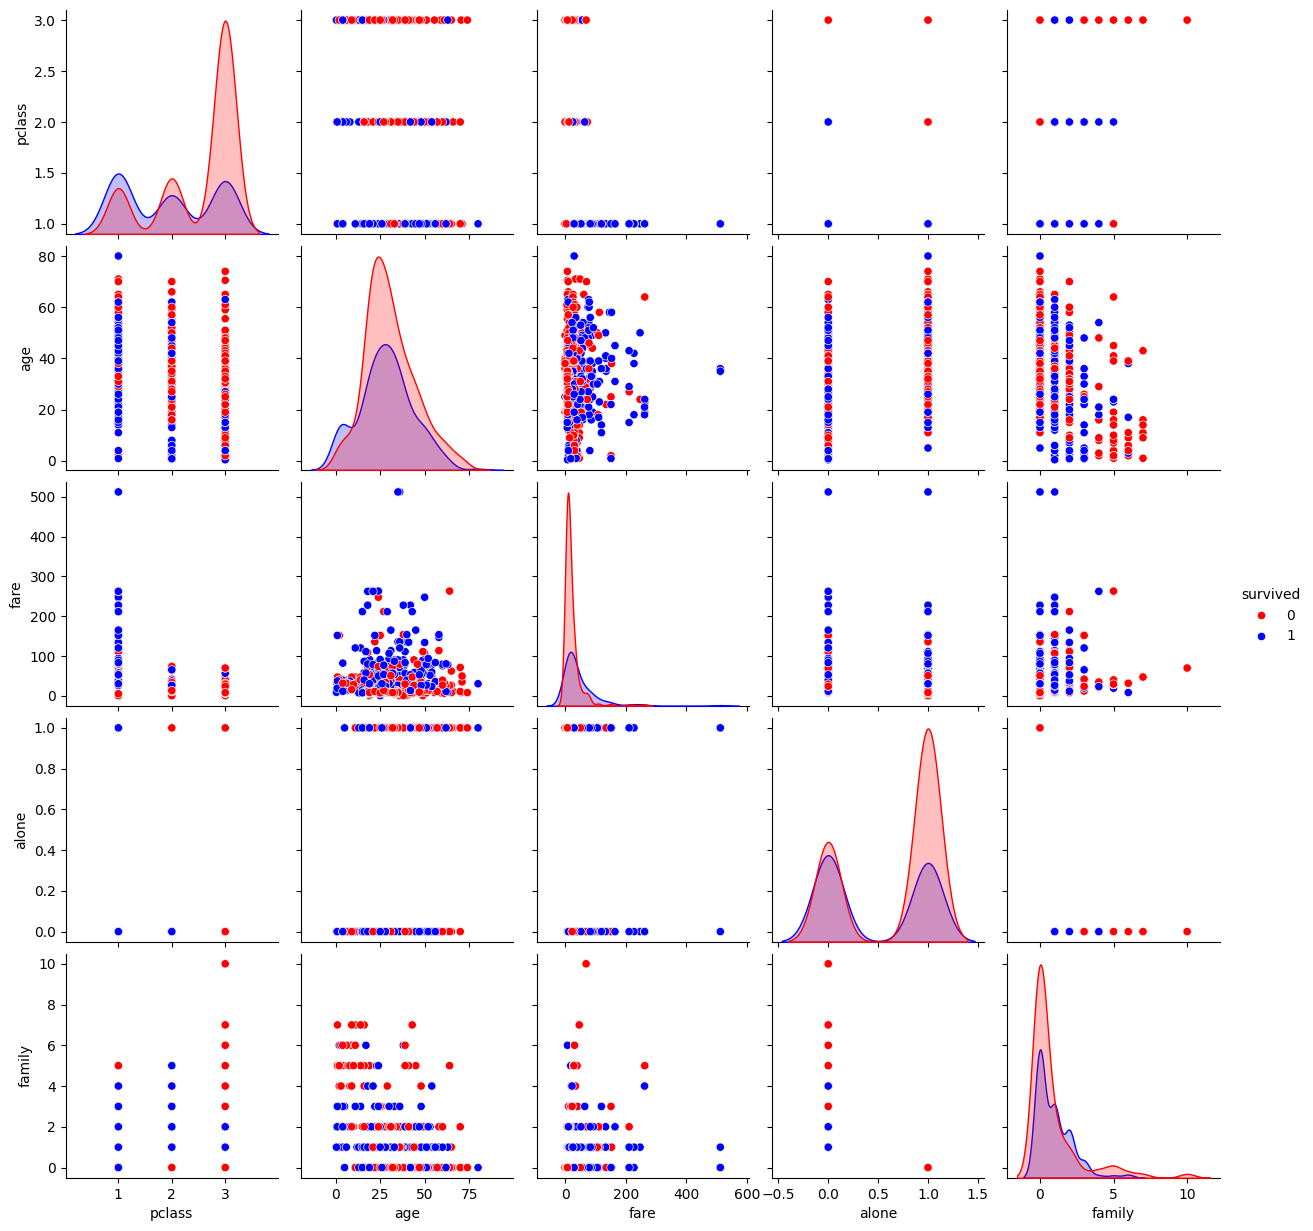

In [7]:
palette = {0: 'red', 1: 'blue'}

sns.pairplot(titanic, hue='survived', palette=palette)

Il semblerait pertinent d'étudier les combinaisons :
- 'fare (prix du billet) en fonction de l'âge'
- 'fare en fonction de adult_male'
- 'pclass en fonction de l'age'
- 'pclass en fonction de family'  

Une idée semble déjà se dessiner : la classe et le prix du billet pourraient avoir un impact sur la survie ou non des passagers...

In [8]:
titanic_2 = pd.get_dummies(titanic, columns=['pclass', 'sex', 'who', 'embark_town'], drop_first=True)

# Supprimer les données manquantes
titanic_2 = titanic_2.dropna()

titanic_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 714 entries, 0 to 890
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   survived                 714 non-null    int64  
 1   age                      714 non-null    float64
 2   fare                     714 non-null    float64
 3   alone                    714 non-null    bool   
 4   family                   714 non-null    int64  
 5   pclass_2                 714 non-null    bool   
 6   pclass_3                 714 non-null    bool   
 7   sex_male                 714 non-null    bool   
 8   who_man                  714 non-null    bool   
 9   who_woman                714 non-null    bool   
 10  embark_town_Queenstown   714 non-null    bool   
 11  embark_town_Southampton  714 non-null    bool   
dtypes: bool(8), float64(2), int64(2)
memory usage: 33.5 KB


On transforme le jeu de données en une matrice X et un vecteur y puis on normalise les données en utilisant la fonction StandardScaler :

In [9]:
X = titanic_2.drop(columns= ['survived']).to_numpy()
y = titanic_2['survived']

In [10]:
test_size = 0.15
X_no_test, X_test, y_no_test, y_test = train_test_split(X, y, test_size=test_size, random_state=4)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_no_test, y_no_test, test_size=0.2, random_state=4)

Meilleur k validation : 34


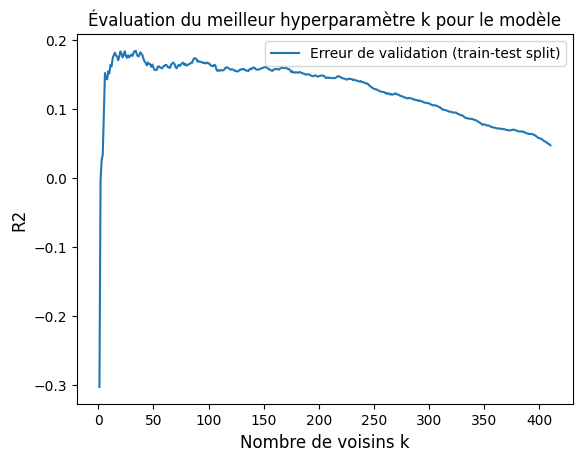

In [12]:
# On cherche à trouver le meilleur paramètre k pour la méthode KNN
nb_training = X_train.shape[0]

r2_table = []
r2_table_validation = []
r2_table_global = []
for k in range(1, int(nb_training*(1-test_size))):
  neigh = KNeighborsRegressor(n_neighbors=k)
  neigh.fit(X_train, y_train)
  r2_table_validation.append(neigh.score(X_val, y_val))


k_opt_val = np.argmax(r2_table_validation) + 1  # C'est le k optimal (max)

print(f"Meilleur k validation : {k_opt_val}")

plt.plot(range(1, int(nb_training*(1-test_size))), r2_table_validation, label="Erreur de validation (train-test split)")
plt.xlabel("Nombre de voisins k", fontsize=12)
plt.ylabel("R2", fontsize=12)
plt.title("Évaluation du meilleur hyperparamètre k pour le modèle", fontsize=12)
plt.legend()
plt.show()

In [13]:
def plot_confusion_matrix(model, X, y):
    # Prédire les classes pour les données d'entrée
    y_pred = model.predict(X)

    # Calculer la matrice de confusion
    cm = confusion_matrix.confusion_matrix(y, y_pred)


    # Afficher la matrice de confusion sous forme de heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non Survécu', 'Survécu'],
                yticklabels=['Non Survécu', 'Survécu'])
    plt.xlabel('Prédit')
    plt.ylabel('Vrai')
    plt.title('Matrice de Confusion')
    plt.show()

# Utiliser la fonction pour tracer la matrice de confusion pour le modèle KNN
plot_confusion_matrix(neigh, X_test, y_test)


ValueError: Classification metrics can't handle a mix of binary and continuous targets